In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, RocCurveDisplay)
import pickle
import time
import warnings


warnings.filterwarnings('ignore')

os.makedirs('models', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)

In [3]:
#load preprocessed data

print("\nDecision Tree Classifier")
print("="*60)

print("\nStep 1: Load preprocessed data")
print("="*60)

with open('models/preprocessed_data.pkl','rb') as f:
    preprocessed_data= pickle.load(f)

feature_names = preprocessed_data['feature_names']
X_train = preprocessed_data['X_train']
X_test = preprocessed_data['X_test']
y_train = preprocessed_data['y_train']
y_test= preprocessed_data['y_test']

print("Data loaded successfully.")
print(f"Training data samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Class distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test): {np.bincount(y_test)}")



Decision Tree Classifier

Step 1: Load preprocessed data
Data loaded successfully.
Training data samples: 8278
Test samples: 1409
Features: 19
Class distribution (train): [4139 4139]
Class distribution (test): [1035  374]


In [4]:
#baseline decision tree model
print("Step 2: Baseline decision tree model")
print("="*60)

print("\nTraining baseline decision tree with default parameters.")

#create the raw decision tree. random_state =42 : get the same result every time
bs_model = DecisionTreeClassifier(random_state=42)

#train the model
bs_model.fit(X_train, y_train)

#make predictions
y_pred_baseline = bs_model.predict(X_test) #return the class directly (0,1)
y_pred_prob_baseline = bs_model.predict_proba(X_test)[:, 1] #return probabilities of classes - extracts prob of churn (class 1) -required for ROC-AUC

#evaluate model
print("Baseline model performance")
print("="*60)

bs_accuracy= accuracy_score(y_test, y_pred_baseline) #percentage of correct predictions

bs_precision = precision_score(y_test, y_pred_baseline) #Of all predicted "Churn" customers, how many actually churned?

bs_recall = recall_score(y_test, y_pred_baseline)#Of all actual churners, how many did the model detect?

bs_f1 = f1_score(y_test, y_pred_baseline) #Harmonic mean of Precision & Recall

bs_roc_auc = roc_auc_score(y_test, y_pred_prob_baseline)
#Measures overall ranking ability of the model: [0.5 - random guessing, 1- perfect]

print(f"Accuracy: {bs_accuracy:.4f}")
print(f"Precision: {bs_precision:.4f}")
print(f"Recall: {bs_recall:.4f}")
print(f"F1-Score: {bs_f1:.4f}")
print(f"ROC-AUC: {bs_roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_baseline, target_names=['No Churn', 'Churn']))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix")
print(cm)




Step 2: Baseline decision tree model

Training baseline decision tree with default parameters.
Baseline model performance
Accuracy: 0.7175
Precision: 0.4729
Recall: 0.5588
F1-Score: 0.5123
ROC-AUC: 0.6666

Classification report:
              precision    recall  f1-score   support

    No Churn       0.83      0.77      0.80      1035
       Churn       0.47      0.56      0.51       374

    accuracy                           0.72      1409
   macro avg       0.65      0.67      0.66      1409
weighted avg       0.73      0.72      0.72      1409


Confusion Matrix
[[802 233]
 [165 209]]


In [5]:
#hyperparameter tuning
print("Step 3: Hyperparameter tuning")
print("="*60)

print("\nDefining hyperparameter grid.")
param_grid={
    'criterion': ['gini', 'entropy'], #how to measure split quality
    'max_depth': [3,5,7,10,15,20, None], #how deep the tree is
    'min_samples_split': [2,5,10,20], #min samples required to split a node
    'min_samples_leaf':[1,2,4,8], #min samples required to form a leaf
    'max_features':['sqrt','log2',None], #number of features to consider at each split
    'class_weight':['balanced',None] #handle cls imbalance
}

print(f"Parameter grid defining with {len(param_grid)} parameters:")
for param, values in param_grid.items():
    print(f" - {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations to test: {total_combinations}")

#GridSearch will test 1344 different model configurations.

#create GridSearchCV object
print("\nInitializing GridSearchCV")
print("- Cross-validation folds: 5")
print("- Scoring metric: F1-score")
print("- Using all CPU cores (n_jobs = -1)")

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), #Base model to tune
    param_grid=param_grid,  #All hyperparameters to try
    cv=5, #5-fold cross-validation
    scoring='f1', #Optimize for F1-score
    n_jobs=-1,
    verbose=2 #Print progress to console
)

#Fit GridSearchCV
print("\nStarting Grid Search ...")
print("="*60)

grid_search.fit(X_train, y_train)
print("Grid search completed.")

# 1.Build a decision tree with hyperparameter combo #1
# 2.Evaluate using 5-fold CV
# 3.Build tree with combo #2
# 4.Evaluate
# 5.… repeat for all 1344 combinations
# 6.Select the best combination based on highest F1-score


#best parameters
print("Best hyperparameters")
print("="*60)
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nBest cross-validation F1-score: {grid_search.best_score_:.4f}")


Step 3: Hyperparameter tuning

Defining hyperparameter grid.
Parameter grid defining with 6 parameters:
 - criterion: ['gini', 'entropy']
 - max_depth: [3, 5, 7, 10, 15, 20, None]
 - min_samples_split: [2, 5, 10, 20]
 - min_samples_leaf: [1, 2, 4, 8]
 - max_features: ['sqrt', 'log2', None]
 - class_weight: ['balanced', None]

Total combinations to test: 1344

Initializing GridSearchCV
- Cross-validation folds: 5
- Scoring metric: F1-score
- Using all CPU cores (n_jobs = -1)

Starting Grid Search ...
Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Grid search completed.
Best hyperparameters
class_weight: None
criterion: entropy
max_depth: 10
max_features: None
min_samples_leaf: 1
min_samples_split: 5

Best cross-validation F1-score: 0.8117


In [6]:
#train final model with best params
print("Step 4: Training optimized decision tree")
print("="*60)

#get best model
dt_optimized = grid_search.best_estimator_

print("\nBest model retrieved.")
print(f"Model parameters: {dt_optimized.get_params()}")
#make predictions

y_pred_opt = dt_optimized.predict(X_test)
y_pred_prob_opt = dt_optimized.predict_proba(X_test)[:, 1]



Step 4: Training optimized decision tree

Best model retrieved.
Model parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [7]:
#evaluate optimized model
print("Step 5: Optimized model evaluation")
print("="*60)

optimized_accuracy = accuracy_score(y_test, y_pred_opt)
optimized_precision = precision_score(y_test, y_pred_opt)
optimized_recall = recall_score(y_test, y_pred_opt)
optimized_f1 = f1_score(y_test, y_pred_opt)
optimized_roc_auc = roc_auc_score(y_test, y_pred_prob_opt)

print("Optimized model performance")
print("="*60)

print(f"Accuracy:  {optimized_accuracy:.4f}")
print(f"Precision: {optimized_precision:.4f}")
print(f"Recall:    {optimized_recall:.4f}")
print(f"F1-Score:  {optimized_f1:.4f}")
print(f"ROC-AUC:   {optimized_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt, target_names=['No Churn', 'Churn']))

#confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_opt)
print(cm_opt)
print(f"\nTrue Negatives: {cm_opt[0,0]}")
print(f"False Positives: {cm_opt[0,1]}")
print(f"False Negatives: {cm_opt[1,0]}")
print(f"True Positives: {cm_opt[1,1]}")



Step 5: Optimized model evaluation
Optimized model performance
Accuracy:  0.7523
Precision: 0.5256
Recall:    0.6872
F1-Score:  0.5956
ROC-AUC:   0.7889

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.87      0.78      0.82      1035
       Churn       0.53      0.69      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.75      0.76      1409

[[803 232]
 [117 257]]

True Negatives: 803
False Positives: 232
False Negatives: 117
True Positives: 257


In [8]:
#compare baseline and optimized

print("Step 6: Baseline VS Optimized comparison")
print("="*60)

comparison_df= pd.DataFrame({
    'Metric':['Accuracy', 'Precision','Recall','F1-Score','ROC-AUC'],
    'Baseline':[bs_accuracy,bs_precision,bs_recall,bs_f1,bs_roc_auc],
    'Optimized': [optimized_accuracy,optimized_precision, optimized_recall, optimized_f1, optimized_roc_auc]
})

comparison_df['Improvement'] = ((comparison_df['Optimized'] - comparison_df['Baseline']) / comparison_df['Baseline']*100).round(2)

print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))
print("\nImprovement Summary:")
for idx, row in comparison_df.iterrows():
    if row['Improvement'] > 0:
        print(f"{row['Metric']}: +{row['Improvement']:.2f}% improvement")
    elif row['Improvement'] < 0:
        print(f"{row['Metric']}: {row['Improvement']:.2f}% decrease")
    else:
        print(f"{row['Metric']}: No change")


Step 6: Baseline VS Optimized comparison

Performance Comparison:
   Metric  Baseline  Optimized  Improvement
 Accuracy  0.717530   0.752307         4.85
Precision  0.472851   0.525562        11.15
   Recall  0.558824   0.687166        22.97
 F1-Score  0.512255   0.595597        16.27
  ROC-AUC  0.666638   0.788854        18.33

Improvement Summary:
Accuracy: +4.85% improvement
Precision: +11.15% improvement
Recall: +22.97% improvement
F1-Score: +16.27% improvement
ROC-AUC: +18.33% improvement


Step 7: Creating Visualizations

1. Confusion matrix comparison


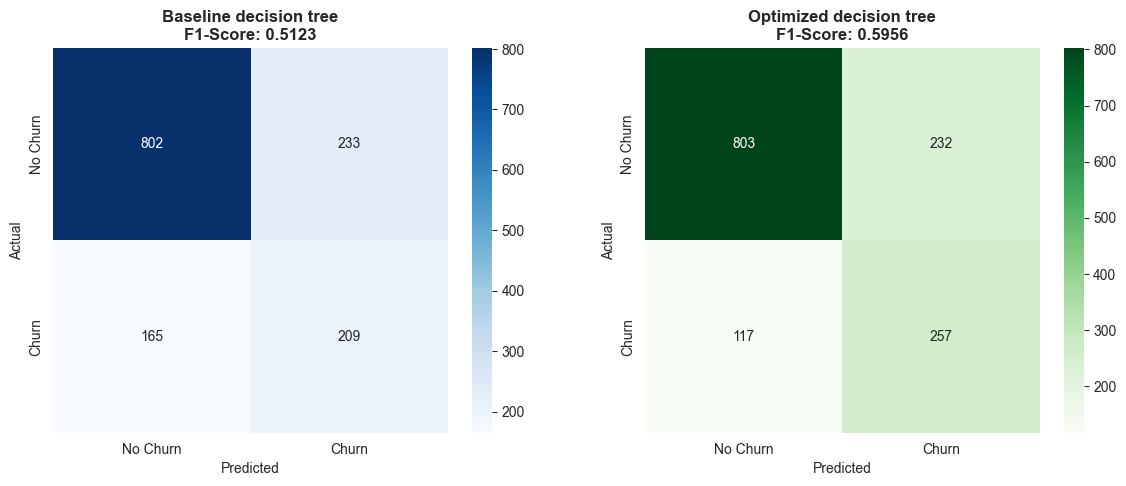

In [16]:
#visualization
print("Step 7: Creating Visualizations")
print("="*70)

#confusion matrix comparison
print("\n1. Confusion matrix comparison")
fig, axes = plt.subplots(1,2,figsize=(14,5))

#baseline
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', ax=axes[0],xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn','Churn'])
axes[0].set_title(f'Baseline decision tree\nF1-Score: {bs_f1:.4f}',fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

#optimized
sns.heatmap(cm_opt,annot=True, fmt='d', cmap='Greens', ax=axes[1],xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn','Churn'])
axes[1].set_title(f'Optimized decision tree\nF1-Score: {optimized_f1:.4f}',fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.show()


2. Performance matrices comparison


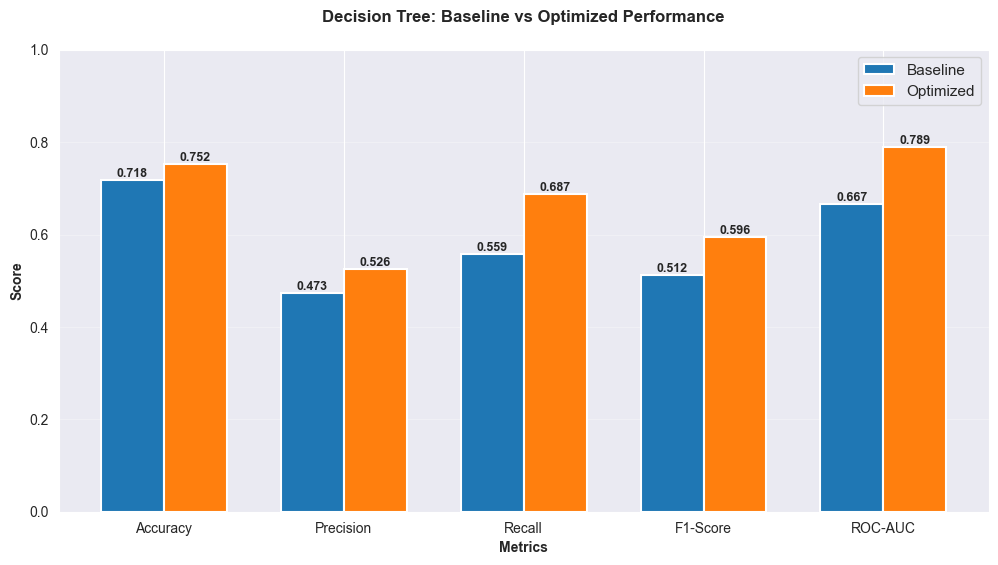

In [17]:
#performance matrices comparison
print("\n2. Performance matrices comparison")
fig, ax = plt.subplots(figsize=(12,6))

x = np.arange(len(comparison_df['Metric']))
width=0.35
bars1 = ax.bar(x- width/2, comparison_df['Baseline'], width, label='Baseline', linewidth=1.5)
bars2= ax.bar(x+ width/2, comparison_df['Optimized'],width, label='Optimized',linewidth=1.5)

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Decision Tree: Baseline vs Optimized Performance', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.show()


3. ROC curve


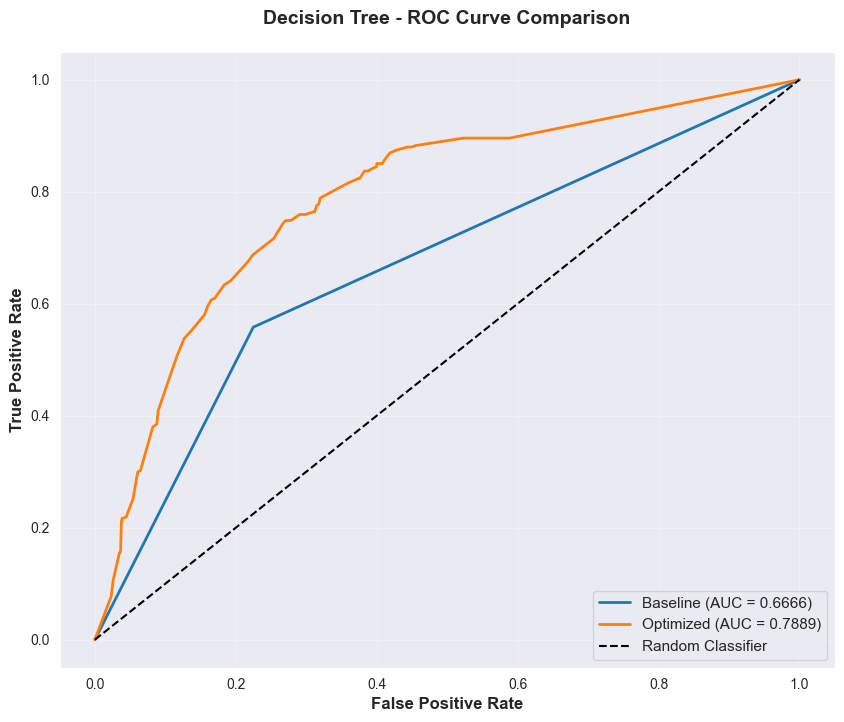

In [18]:
#ROC curve
print("\n3. ROC curve")
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_prob_baseline)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_prob_opt)

plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {bs_roc_auc:.4f})', linewidth=2)
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized (AUC = {optimized_roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Decision Tree - ROC Curve Comparison', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

plt.show()


4.Precision-Recall curve


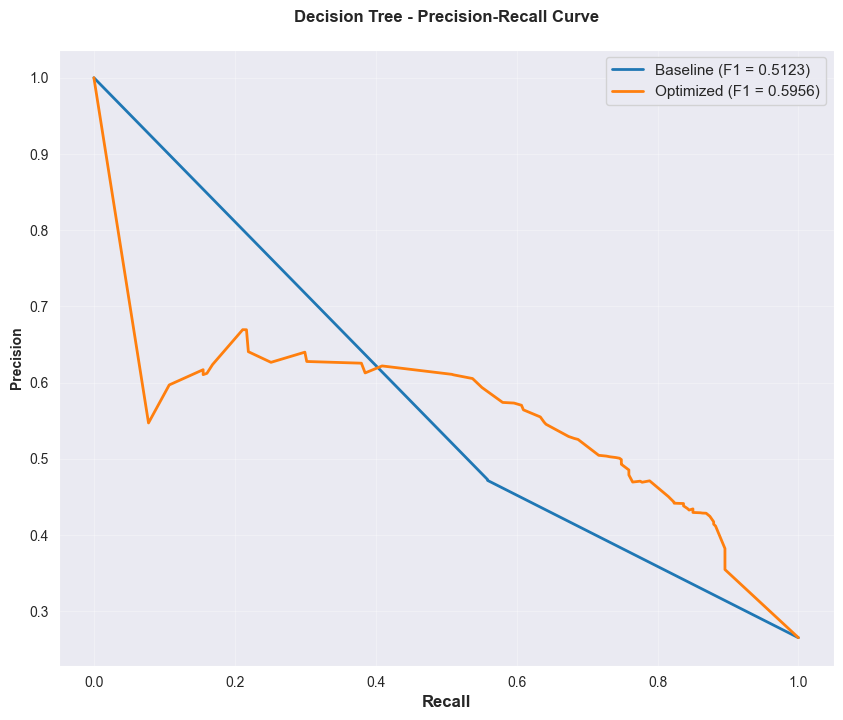

In [19]:
#precision recall curve
print("\n4.Precision-Recall curve")
precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_prob_baseline)
precision_optimized, recall_optimized, _ = precision_recall_curve(y_test, y_pred_prob_opt)

plt.figure(figsize=(10, 8))
plt.plot(recall_baseline, precision_baseline, label=f'Baseline (F1 = {bs_f1:.4f})', linewidth=2)
plt.plot(recall_optimized, precision_optimized, label=f'Optimized (F1 = {optimized_f1:.4f})', linewidth=2)

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision',fontweight='bold')
plt.title('Decision Tree - Precision-Recall Curve',fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)

plt.show()


Step 8: Feature importance analysis

Top 10 Most Important Features:
         Feature  Importance
        Contract    0.476399
  MonthlyCharges    0.105750
          tenure    0.071856
  OnlineSecurity    0.065060
   PaymentMethod    0.063357
    TotalCharges    0.058109
 InternetService    0.037141
     TechSupport    0.023517
PaperlessBilling    0.020205
          gender    0.014211


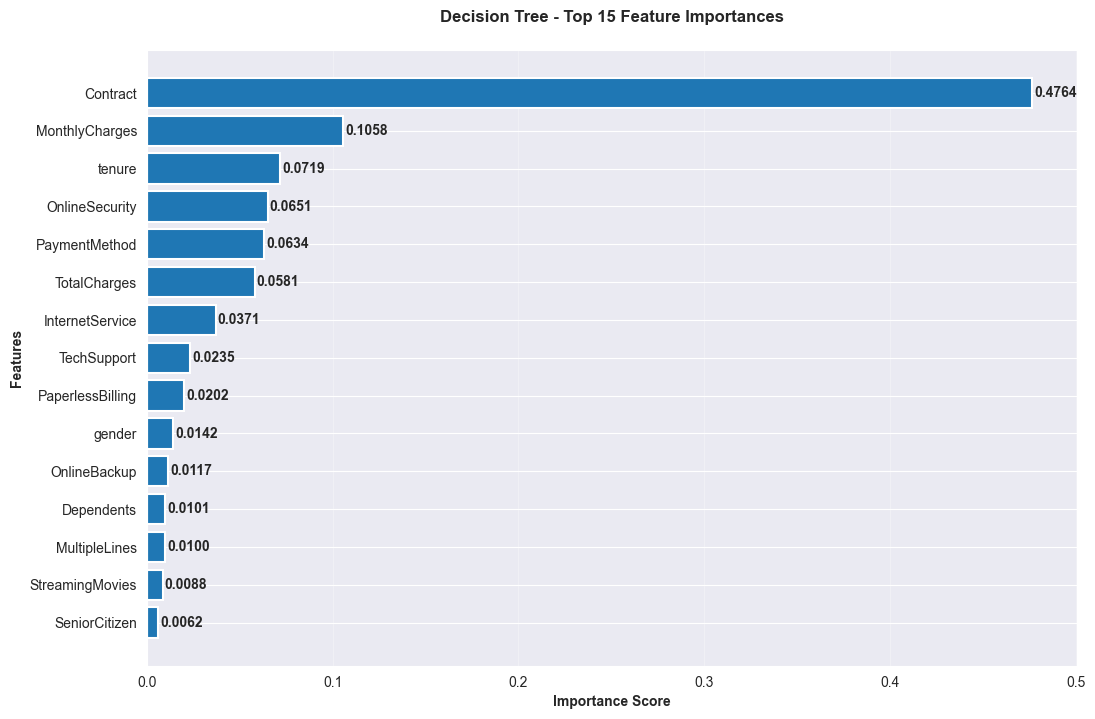

Feature importance data saved to: results/dt_feature_importance.csv


In [23]:
#Feature importance
print("Step 8: Feature importance analysis")
print("="*60)

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance':dt_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

#visualize
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)

plt.barh(range(len(top_features)), top_features['Importance'],linewidth=1.5)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score',fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.title('Decision Tree - Top 15 Feature Importances',fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center',fontweight='bold')

plt.show()

feature_importance.to_csv('results/dt_feature_importance.csv', index=False)
print("Feature importance data saved to: results/dt_feature_importance.csv")


Step 9: Decision tree visualization


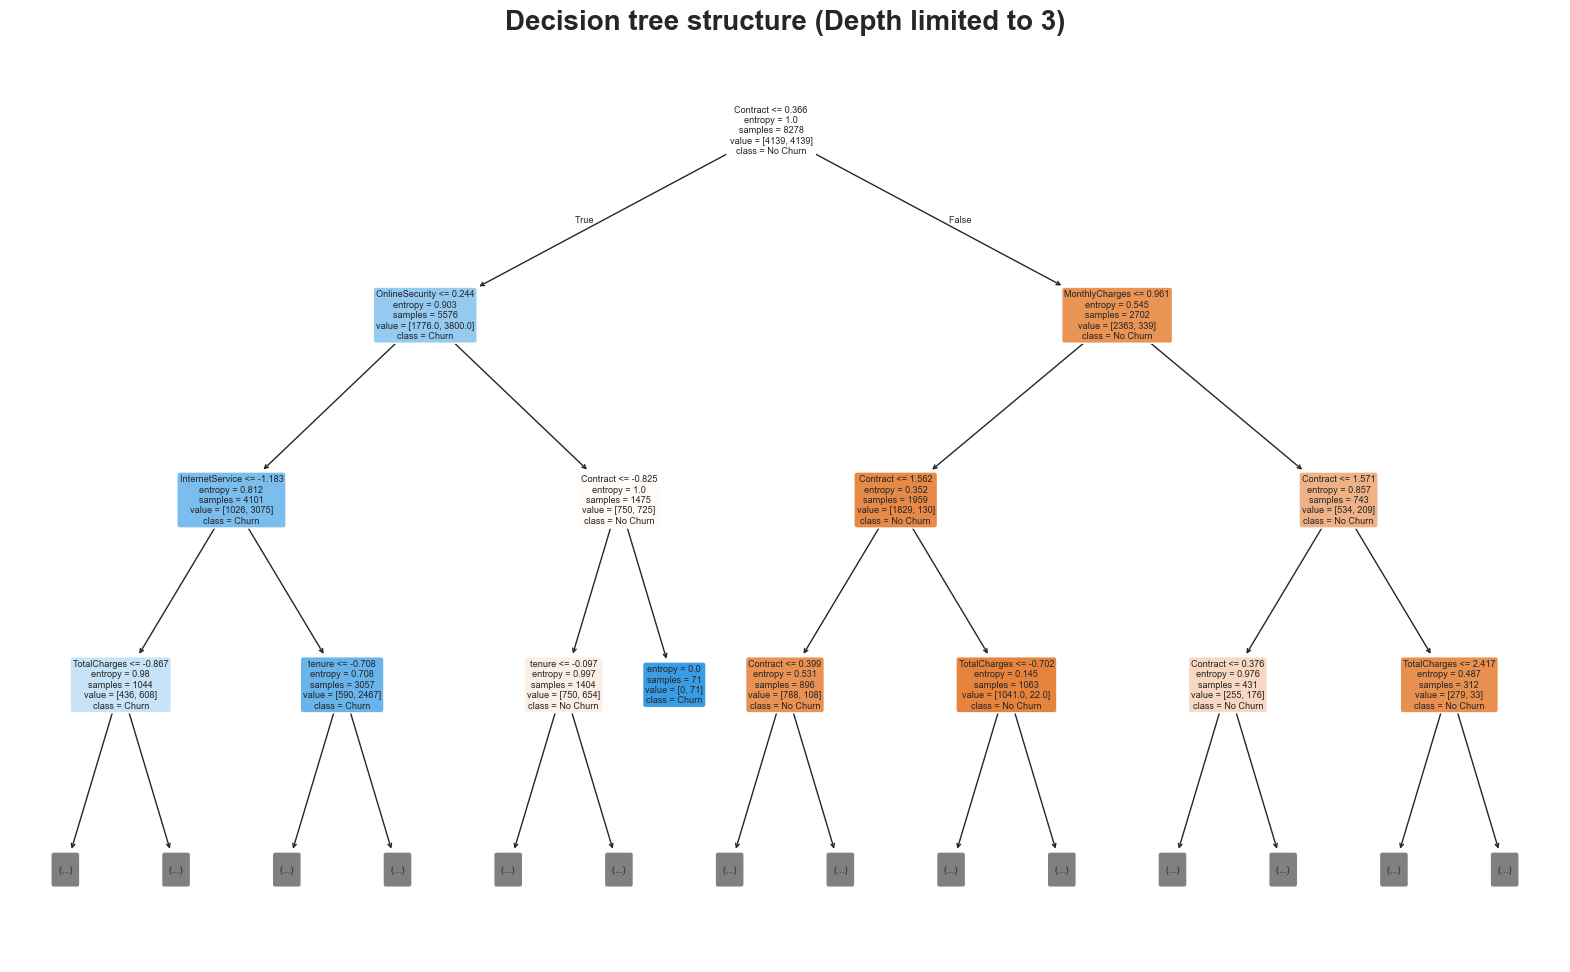

In [26]:
#decision tree visualization
print("Step 9: Decision tree visualization")
print("="*60)

plt.figure(figsize=(20,12))
plot_tree(dt_optimized,
          max_depth=3,
          feature_names=feature_names,
          class_names=['No Churn', 'Churn'],
          filled=True,
          rounded=True)

plt.title('Decision tree structure (Depth limited to 3)',fontsize=20, fontweight='bold')
plt.show()

Step 10: Cross validation analysis

Performing 10-fold cross-validation on optimized model...

Cross-Validation F1-Scores (10 folds):
  Fold  1: 0.7491
  Fold  2: 0.7494
  Fold  3: 0.7559
  Fold  4: 0.7783
  Fold  5: 0.8747
  Fold  6: 0.8530
  Fold  7: 0.8507
  Fold  8: 0.8481
  Fold  9: 0.8315
  Fold 10: 0.8489

Cross-Validation Summary:
  Mean F1-Score: 0.8140
  Std Deviation: 0.0472
  Min F1-Score:  0.7491
  Max F1-Score:  0.8747


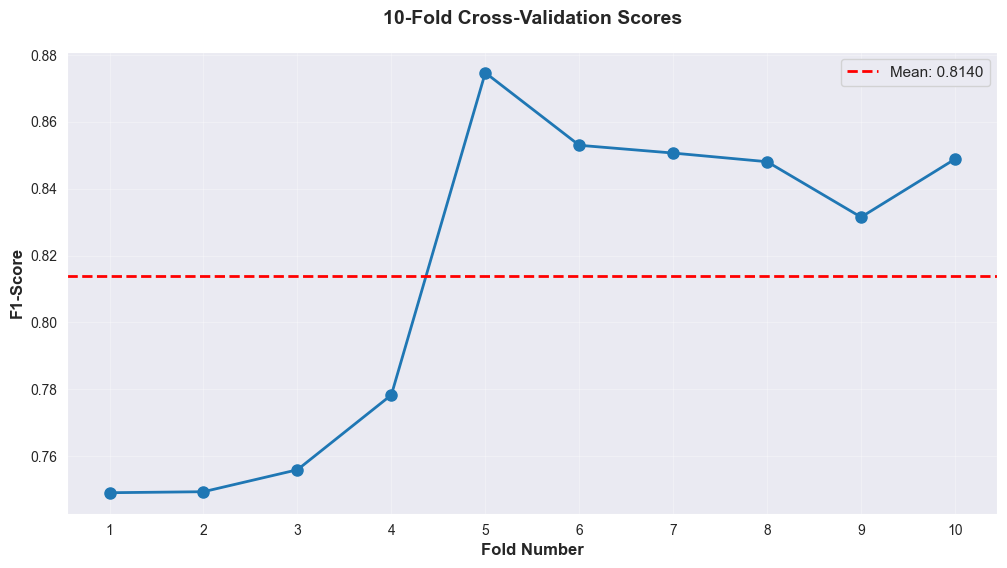

In [27]:
#cross validation analysis
print("Step 10: Cross validation analysis")
print("="*60)

print("\nPerforming 10-fold cross-validation on optimized model...")

cv_scores = cross_val_score(dt_optimized, X_train, y_train, cv=10, scoring='f1')

print(f"\nCross-Validation F1-Scores (10 folds):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i:2d}: {score:.4f}")

print(f"\nCross-Validation Summary:")
print(f"  Mean F1-Score: {cv_scores.mean():.4f}")
print(f"  Std Deviation: {cv_scores.std():.4f}")
print(f"  Min F1-Score:  {cv_scores.min():.4f}")
print(f"  Max F1-Score:  {cv_scores.max():.4f}")

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('10-Fold Cross-Validation Scores', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(range(1, 11))

plt.show()

In [28]:
#save model
print("Step 11: Save trained model")
print("="*60)

with open('models/decision_tree_model.pkl','wb') as f:
    pickle.dump(dt_optimized,f)

print("Optimized Decision Tree model saved to: models/decision_tree_model.pkl")

results={
    'baseline':{
        'accuracy':bs_accuracy,
        'precision':bs_precision,
        'recall':bs_recall,
        'f1_score':bs_f1,
        'roc_auc':bs_roc_auc,
        'confusion matrix':cm
    },
    'optimized':{
        'accuracy': optimized_accuracy,
        'precision': optimized_precision,
        'recall': optimized_recall,
        'f1_score': optimized_f1,
        'roc_auc': optimized_roc_auc,
        'confusion_matrix': cm_opt,
        'best_params': best_params
    },
    'feature_importance': feature_importance,
    'cv_scores':cv_scores
}

with open('models/decision_tree_results.pkl','wb') as f:
    pickle.dump(results,f)

print("All results saved to: models/decision_tree_results.pkl")


Step 11: Save trained model
Optimized Decision Tree model saved to: models/decision_tree_model.pkl
All results saved to: models/decision_tree_results.pkl


In [ ]:
#summary report
print("")